## Import dependencies

In [2]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [3]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 72.4 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
from spellchecker import SpellChecker

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.11.12
Tensorflow version: 2.18.0
Keras version: 3.8.0


## Download the dataset

In [5]:
cache_dir = './tmp'
dataset_file_name = 'sherlockholmes.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = 'shakespeare.txt'

print(dataset_file_path)

shakespeare.txt


In [6]:
import urllib.request
import os

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
dataset_file_name = "shakespeare.txt"

if not os.path.exists(dataset_file_name):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_file_name)
else:
    print("Dataset already exists.")

# Load the text
with open(dataset_file_name, 'r') as file:
    text = file.read()

print(f"Loaded {len(text)} characters.")

Loaded 1115394 characters.


## Analyze the dataset

In [7]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [8]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [9]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [14]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [15]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [16]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [17]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [18]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [16]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [19]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [20]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [21]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [20]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [21]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 (np.str_('F'))
  expected output: 47 (np.str_('i'))
Step  1
  input: 47 (np.str_('i'))
  expected output: 56 (np.str_('r'))
Step  2
  input: 56 (np.str_('r'))
  expected output: 57 (np.str_('s'))
Step  3
  input: 57 (np.str_('s'))
  expected output: 58 (np.str_('t'))
Step  4
  input: 58 (np.str_('t'))
  expected output: 1 (np.str_(' '))


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [22]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [23]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [24]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 5 57 58 ...  1 58 46]
 [43 52 43 ... 53 60 43]
 [46 47 57 ... 57 43 43]
 ...
 [44 56 53 ... 46 39 52]
 [43 42  1 ... 57  1 40]
 [47 41 43 ...  7 61 53]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[57 58  1 ... 58 46 43]
 [52 43 58 ... 60 43 56]
 [47 57  1 ... 43 43  1]
 ...
 [56 53 51 ... 39 52 42]
 [42  1 44 ...  1 40 43]
 [41 43  6 ... 61 53 50]], shape=(64, 100), dtype=int64)


In [25]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [26]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[5 9 5 2 6 9 0 9]
 [6 3 8 2 4 1 1 8]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-4.6811998e-05  4.3235794e-03 -4.1754354e-02  3.0019764e-02
   -6.1382763e-03]
  [ 4.8906207e-03 -6.5658912e-03  3.6384668e-02 -4.3982115e-02
    2.7079429e-02]
  [-4.6811998e-05  4.3235794e-03 -4.1754354e-02  3.0019764e-02
   -6.1382763e-03]
  [-1.1146449e-02 -4.4132471e-03 -1.3424147e-02 -2.2740258e-02
    2.0812247e-02]
  [ 3.3075679e-02 -1.1669792e-02 -1.3073683e-03 -1.3901234e-02
    1.2864735e-02]
  [ 4.8906207e-03 -6.5658912e-03  3.6384668e-02 -4.3982115e-02
    2.7079429e-02]
  [-3.4422565e-02 -5.8365092e-03 -2.5097227e-02  1.5595388e-02
   -1.9863427e-02]
  [ 4.8906207e-03 -6.5658912e-03  3.6384668e-02 -4.3982115e-02
    2.7079429e-02]]

 [[ 3.3075679e-02 -1.1669792e-02 -1.3073683e-03 -1.3901234e-02
    1.2864735e-02]
  [-2.3692548e-02 -1.6914237e-02  4.6580683e-02 -2.8907562e-02
   -2.1840513e-02]


In [27]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [28]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(batch_input_shape=[batch_size, None]))

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim
    ))


    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model



In [29]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (64, None, 256)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, None, 1024)       │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, None, 65)         │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

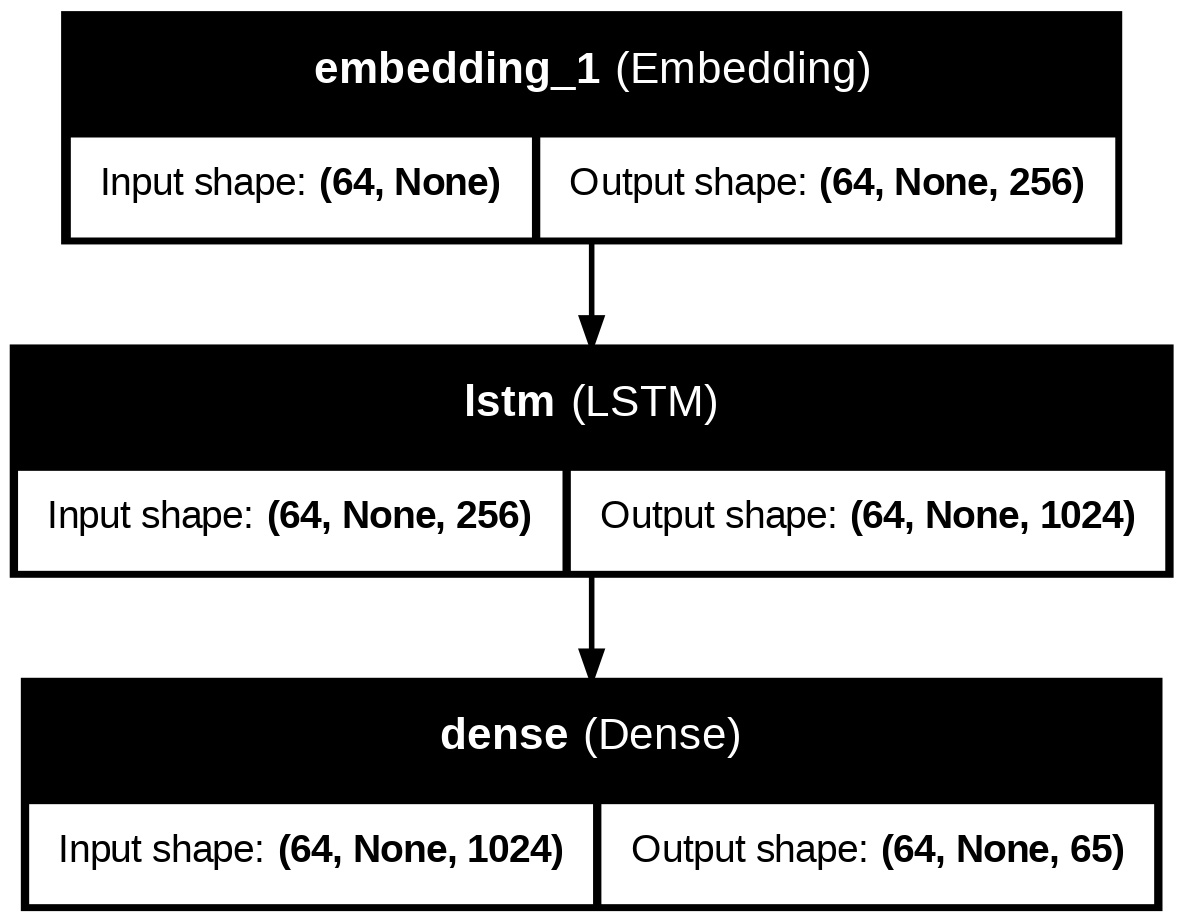

In [31]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [32]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [33]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-3.4734812e-03  2.5185382e-03  3.1643892e-03 -4.4435342e-03
  3.6218064e-03  7.5885662e-05  4.1231752e-04 -9.6955884e-04
 -2.7346993e-03 -1.8920050e-03  7.2625512e-03  1.3870329e-03
  7.4166816e-04  1.5853643e-03 -1.9855579e-04 -9.9030486e-04
  5.7298508e-03 -1.6611975e-03 -1.0728616e-03 -7.6398635e-03
  4.6342006e-03  2.7936057e-03  3.9780783e-03  3.5788682e-03
  4.9523136e-05  1.5702944e-04 -1.9063962e-04 -4.1473438e-03
  1.8917045e-03 -2.6209576e-03 -3.6763693e-03  1.3553347e-04
  2.2717097e-03  5.4611629e-03  1.0337788e-03  3.8632522e-03
  6.4683374e-04 -4.5034024e-03 -5.0010881e-04 -5.7908747e-04
 -1.2617881e-03  2.4366982e-03 -8.3891209e-05  8.4718817e-04
 -6.6037513e-03 -3.1923910e-04  9.2328870e-04 -6.3544856e-03
 -6.7803711e-03  5.6792204e-03  5.0555053e-03  1.1877983e-03
 -4.0892558e-03  1.4434513e-03 -2.3828990e-04 -1.5060266e-03
  1.8265063e-03 -5.9366028e-04  3.2485379e-03  1.9490675e-03
 -3.3818490e-03  

In [34]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 1 1]], shape=(1, 5), dtype=int64)


In [35]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [36]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [37]:
sampled_indices

array([47, 44, 39, 55, 48,  5, 55, 57, 15, 15, 10,  9,  8, 12, 29,  7, 47,
       46, 52, 50, 13, 43, 43, 52,  1, 30, 55, 31, 33, 25, 21, 45,  1, 64,
        8, 49, 34,  6, 22, 61, 56, 62, 20, 50, 42, 24, 22,  5, 53,  3, 16,
       61, 37, 43,  6, 47, 24, 57,  3, 41,  3, 46, 23, 35, 60, 17, 52, 51,
       55, 33, 14, 33, 57,  7, 37, 57, 40, 36,  1, 54, 25, 26, 12, 17, 21,
       25, 40, 17, 25, 18, 24, 64, 17,  4, 62, 26, 57, 24, 51, 32])

In [38]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 " army; and himself,\nLord Clifford and Lord Stafford, all abreast,\nCharged our main battle's front, a"

Next char prediction:
 "ifaqj'qsCC:3.?Q-ihnlAeen RqSUMIg z.kV,JwrxHldLJ'o$DwYe,iLs$c$hKWvEnmqUBUs-YsbX pMN?EIMbEMFLzE&xNsLmT"


In [39]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 1 (np.str_(' '))
  next predicted: 1 (np.str_('i'))
Prediction  1
  input: 39 (np.str_('a'))
  next predicted: 1 (np.str_('f'))
Prediction  2
  input: 56 (np.str_('r'))
  next predicted: 1 (np.str_('a'))
Prediction  3
  input: 51 (np.str_('m'))
  next predicted: 1 (np.str_('q'))
Prediction  4
  input: 63 (np.str_('y'))
  next predicted: 1 (np.str_('j'))


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [40]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1744967


In [41]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [42]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}.weights.h5')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [43]:
EPOCHS=40

In [44]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 2.8923
Epoch 2/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 1.8752
Epoch 3/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 1.6196
Epoch 4/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 1.4905
Epoch 5/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 1.4121
Epoch 6/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 1.3564
Epoch 7/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 1.3165
Epoch 8/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 1.2815
Epoch 9/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 1.2456
Epoch 10/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 1.2144
Epoch 11/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 1.1840
Epoch 12/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - loss: 1.1507
Epoch 13/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 1.1206
Epoch 14/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 1.0841
Epoch 15/40
172/172 ━━━━━━━━━

In [45]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

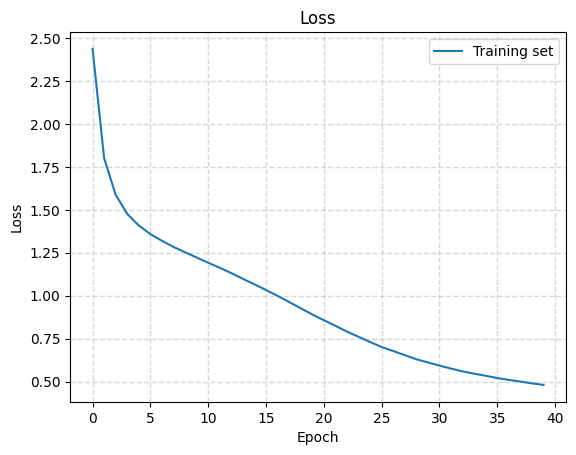

In [46]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [1]:
tf.train.latest_checkpoint(checkpoint_dir)

NameError: name 'tf' is not defined

In [48]:
tf.train.latest_checkpoint(checkpoint_dir)
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights('tmp/checkpoints/ckpt_40.weights.h5')

model.build(tf.TensorShape([simplified_batch_size, None]))

In [49]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, None, 256)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, None, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, None, 65)          │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [50]:
import glob

# Get list of all weight files
weight_files = glob.glob(os.path.join(checkpoint_dir, '*.weights.h5'))

if weight_files:
    latest = max(weight_files, key=os.path.getctime)  # or sort by name, etc.
    model.load_weights(latest)
    print(f"Loaded weights from: {latest}")
else:
    print("No weights file found. Using randomly initialized model.")

Loaded weights from: tmp/checkpoints/ckpt_40.weights.h5


In [51]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.

def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    # Reset states for RNN layers if they are stateful
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))
print(generate_text(model, start_string=u"Sherlock: "))

Sherlock: I'll not go.

GRUMIO:
Nay, come, you must not.

ARCHIDAMUS:
To the object thereforent,
But ne'er till night, I main, 'tis cholering womb,
Brother of demends of day. My vouch, I hear, my old dis form your fearful heart to him:
Give him some brave tooth our steps of bidding.

BAPTISTA:
Is, mistress, 'rieve not one distinguishman: you were king,
And I not dieed, but surely: you shall not wantono parton writ in my love.

VINCENTIO:
Away, my lord; there is my king of heaven's condemned,
As fill my husband bid me, being thread,
And there renearned to are yet: I will pity those.
Th-God shallow Rudis.
The grey-eyeddings of their pure worserve's in Rome, nor of your worship,
Is priests and home, be mighty live; he stands--
Since birthen tyrannous and graceful steals,
When, as survey shed
Thy kinsman's wife another friends: but I'll swear,'
Had to demand,
In her young princess' golden storm
Have spent time stars erought for you would last not mine.

RIVERS:
His duty is your king, and n

In [52]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Sherlock: "))

Sherlock: what
have I have said that broken from me,
Hath let the powder of his oath provoked me.
Nay, rather now fight with grief, as it is,
Your wrongs in wrath o'erwhelm their admire:
Amen.

ANTONIO:
Which once,
God knows what hath yet do thee me r?

Second Officer:
Hell, out or fair.

SICINIUS:
Gentlemen, cundit fight!

AUTOLYCUS:
What will you go? Heaven ends the old so few word Erchip the people.

SICINIUS:
Faith, one work.
The world is fallen flower.

MENENIUS:
Well, well, we will sub with much contented
In that I would believe my business for yourself,
To wink me from this malice done.

MIRANDA:
Well, there went.
I woour with a bond.

AUTOLYCUS:
I crave no time to plead forth it of my head
And this usleen'd villains, whiles I last right on the other.
The very be deserved the freshness which looks right.

ROMEO:
Out--

SEBASTIAN:
O most pertilet, make key
which is the trust to the one.

ISABELLA:
As much for my lips in the duke.

ESCALUS:
How! knife, good nurse, be it forgive;
Y

In [53]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"Sherlock: ", temperature=1.5))

Sherlock: I swear it.

First Citizen:
If ey;
And that omit there's honest ll serve I, Sir Cobesenes,
Signior Lauching and no mistress, I must appear.

AUFIDIUS:
Ever followed of thy disposition.

FRIAR THOMAS:
Tell him whatever poxeex-

JULOLIO:
So 'twas much: sesu it
shall exil
Le:
In sudden, then to Cote, sisters have been, to God,
Ay, pility, any thing banishment.

TRANIO:
Minbetime unquepose and freedom as my weak.
Good night, let us not deposee well choose himself will wash
He does in vain comes full outwoward.

JULIET:
Show me this hour mother?

DUCHESS OF YOLK:
Who have the king! Would Warwick, and a queen;
but thinks a netther grief.
Your feath, my lord, wis face,
Nothing, muffle nothing spake himself.
If fair nine, the duke's not strike,
And bite your trade; I'll bear thee in your name
Is grace meane you talk of amity
Within my commission, that I have
not high, go back.
Your execution3RYORK:
Go to ime; your grace shall be hanged.
God save Vincentio topprison; other dain led me

## Explore impact of temperature

In [54]:
def evaluate_spelling_accuracy(generated_text):

    # Initialize spell checker
    spell = SpellChecker(language='en')

    # Clean the text and split into words
    cleaned_text = re.sub(r'[^\w\s]', ' ', generated_text.lower())
    words = [word for word in cleaned_text.split() if word.strip()]

    words = [word for word in words if word.isalpha() and len(word) > 1]

    # Count total words
    total_words = len(words)

    if total_words == 0:
        return {
            "correct_words": 0,
            "incorrect_words": 0,
            "total_words": 0,
            "spelling_accuracy": 0.0,
            "most_common_incorrect": []
        }

    # Find misspelled words
    misspelled = spell.unknown(words)

    # Count correct words
    correct_words = total_words - len(misspelled)

    # Calculate spelling accuracy
    spelling_accuracy = (correct_words / total_words) * 100

    # Get most common incorrect words
    incorrect_counter = Counter(misspelled)
    most_common_incorrect = incorrect_counter.most_common(10)

    # Return metrics
    return {
        "correct_words": correct_words,
        "incorrect_words": len(misspelled),
        "total_words": total_words,
        "spelling_accuracy": spelling_accuracy,
        "most_common_incorrect": most_common_incorrect
    }

In [55]:
start_string = "Sherlock Holmes looked at me with a smile. "
temperatures = [0.2, 0.5, 0.7, 1.0, 1.3, 1.7, 2.0]

for temp in temperatures:
    print(f"\n=== TEMPERATURE: {temp} ===\n")
    generated_text = generate_text(
        model,
        start_string=start_string,
        num_generate=300,
        temperature=temp
    )
    print(generated_text)


=== TEMPERATURE: 0.2 ===

Sherlock Holmes looked at me with a smile. Away with him
to prison! lay before their oaths;
And when my father well have me for your countenance,
Is 't not changed in the bottom of the sea:
Some lay in dead men's tongue,
Being only heir to all, my lord, and hear me speak.

KING RICHARD II:
I have been such as stands in like request,
And be n

=== TEMPERATURE: 0.5 ===

Sherlock Holmes looked at me with a smile. He tell me, I beseech you,
By all in arms gentlemen, but to repent
The heads of his agreement from their lives.
But is the man what he did but see
Here comes with wrath. Come all this land,
That I have been the wild with oaths,
Should yet say 'Sir, no going.' Verily,
You will not for your weapons, n

=== TEMPERATURE: 0.7 ===

Sherlock Holmes looked at me with a smile. Putting them thither
How doth he lose him.

HENRY BOLINGBROKE:
Of much less, say I shall interchange
From whence that told me here at Oxford fld dream;
For on that I, a good lords, take yo

In [57]:
import re
from collections import Counter

def analyze_text(text, original_prompt_length):
    # Analyze only the generated portion
    generated_text = text[original_prompt_length:]

    # Word diversity (higher = more diverse vocabulary)
    words = re.findall(r'\b\w+\b', generated_text.lower())
    word_diversity = len(set(words)) / len(words) if words else 0

    # Repetition rate (higher = more repetition)
    word_counts = Counter(words)
    repetitions = sum(count - 1 for count in word_counts.values())
    repetition_rate = repetitions / len(words) if words else 0

    # Average sentence length
    sentences = re.split(r'[.!?]+', generated_text)
    sentences = [s for s in sentences if s.strip()]
    avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences) if sentences else 0

    # Spelling accuracy
    spelling_accuracy = evaluate_spelling_accuracy(generated_text)['spelling_accuracy']

    return {
        "word_diversity": word_diversity,
        "repetition_rate": repetition_rate,
        "avg_sentence_length": avg_sentence_length,
        "spelling_accuracy" : spelling_accuracy
    }

results = {}
for temp in temperatures:
    # Generate 5 samples per temperature for more reliable metrics
    metrics = []
    for _ in range(5):
        text = generate_text(model, start_string, 300, temp)
        metrics.append(analyze_text(text, len(start_string)))

    # Average the metrics
    results[temp] = {k: sum(m[k] for m in metrics)/len(metrics) for k in metrics[0]}

In [75]:
# Print the results
print(f"{'Temperature':<12} {'Word Diversity':<18} {'Repetition Rate':<18} {'Avg Sentence Length':<24} {'Spelling accuracy'}")
print("-" * 100)

for temp in sorted(results):
    metrics = results[temp]
    print(f"{temp:<12} {metrics['word_diversity']:<18.3f} {metrics['repetition_rate']:<18.3f} {metrics['avg_sentence_length']:<24.3f} {metrics['spelling_accuracy']:0.2f}")


Temperature  Word Diversity     Repetition Rate    Avg Sentence Length      Spelling accuracy
----------------------------------------------------------------------------------------------------
0.2          0.822              0.178              23.187                   94.79
0.5          0.826              0.174              20.967                   96.64
0.7          0.893              0.107              12.921                   93.09
1.0          0.887              0.113              13.824                   91.34
1.3          0.902              0.098              12.593                   86.53
1.7          0.907              0.093              13.000                   81.96
2.0          0.936              0.064              11.061                   71.14


In [22]:
def visualize_next_char_distribution(model, prompt, temperatures=[0.5, 1.0, 1.5], char2index=None, index2char=None):
    """Visualize how temperature affects the probability distribution of the next character prediction."""

    # Convert prompt to input indices
    input_indices = [char2index[s] for s in prompt]
    input_indices = tf.expand_dims(input_indices, 0)  # Shape: (1, len(prompt))

    # Run the model and get the last time step's predictions
    predictions = model(input_indices)
    predictions = tf.squeeze(predictions, 0)[-1]  # Shape: (vocab_size,)

    # Compute base probabilities to determine top-k characters (for consistent x-axis)
    base_probs = tf.nn.softmax(predictions).numpy()
    top_indices = np.argsort(base_probs)[-10:][::-1]  # Top 10 indices
    top_chars = [index2char[i] for i in top_indices]

    # Create plot
    plt.figure(figsize=(12, len(temperatures) * 3))

    for i, temp in enumerate(temperatures):
        scaled_logits = predictions / temp
        scaled_probs = tf.nn.softmax(scaled_logits).numpy()

        plt.subplot(len(temperatures), 1, i + 1)
        plt.bar(top_chars, scaled_probs[top_indices])

visualize_next_char_distribution(
    model,
    "Sherlock Holmes looked at th",
    temperatures=[0.3, 1.0, 2.0],
    char2index=char2index,
    index2char=index2char
)


NameError: name 'model' is not defined

## Save the model

In [ ]:
model_name = 'text_generation_sherlock_rnn.h5'
model.save(model_name)

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.